### 📘 Notebook Purpose:

> Build a **Markov-based transition analysis** from unsupervised clustering results to support **strategy decisions**, using metrics like **stickiness**, **most likely next regime**, and **transition entropy**.

---

### ✅ Step-by-step Build Plan

We'll go one section at a time:

1. **Load and preview cluster data**
2. **Compute the transition count matrix**
3. **Normalize to transition probability matrix**
4. **Extract stickiness per cluster**
5. **Extract most likely next regime**
6. **Compute transition entropy**
7. **Combine into decision table**
8. *(Optional)* Visualize with seaborn heatmap




In [94]:
import pandas as pd
import os
from os import path

import numpy as np

from scipy.stats import entropy

from regimetry.config import Config
from regimetry.logger_manager import LoggerManager


In [95]:
logging = LoggerManager.get_logger("regime_transistion_analysis")

In [96]:
cfg = Config()
print("PROJECT ROOT:", cfg.PROJECT_ROOT)
print("BASE DIR:", cfg.BASE_DIR)
print("RAW DATA:", cfg.RAW_DATA_DIR)
print("PROCESSED DATA:", cfg.PROCESSED_DATA_DIR)
print("EMBEDDINGS DATA:", cfg.EMBEDDINGS_DIR) 
print("REPORTS DATA:", cfg.REPORTS_DIR) 

PROJECT ROOT: /Users/kenneth/Public/projects/python/ai/regimetry
BASE DIR: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts
RAW DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/raw
PROCESSED DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/processed
EMBEDDINGS DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/embeddings
REPORTS DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/reports


### ✅ Step 1: Load and Preview Cluster Data

In [97]:
# Load your regime-labeled CSV file
file_path = path.join(cfg.REPORTS_DIR,"CAD_CHF_ws5_learnable80_nc10", "cluster_assignments.csv")
df = pd.read_csv(file_path)
print(df.shape)
df = df.dropna()
print(df.shape)
# Preview the first few rows
df.head()


(1877, 54)
(1873, 54)


,Open,High,Low,Close,Volume,Predictions,Confidence,ATR,AHMA,Leavitt_Projection,...,Momentum_Divergence_Bull,Momentum_Divergence_Bear,Classic_Divergence_Bull,Classic_Divergence_Bear,RHD_Bull,RHD_Bear,Day_Of_Week,Month,Year,Cluster_ID
4,0.72811,0.72814,0.72244,0.72494,65076,0,0.561830,0.005999,0.728849,0.730586,...,0,0,0,0,Strong,Strong,6,3,2018,7.0
5,0.72494,0.73066,0.72318,0.73044,58369,2,0.945805,0.006197,0.727870,0.728179,...,0,0,0,0,Strong,Strong,0,3,2018,7.0
6,0.73044,0.73187,0.72394,0.73075,75422,1,0.792604,0.006428,0.727938,0.726169,...,0,0,0,1,Strong,Weak,1,3,2018,7.0
7,0.73075,0.73810,0.73018,0.73746,67610,2,0.953897,0.006627,0.730362,0.726066,...,1,0,0,0,Strong,Strong,2,3,2018,7.0
8,0.73746,0.74278,0.73666,0.74232,63826,1,0.460519,0.006559,0.734367,0.728449,...,0,0,0,0,Strong,Strong,3,3,2018,7.0


### ✅ Step 2: Compute Transition Count Matrix

In [98]:
# Extract cluster series as integer values
cluster_series = df["Cluster_ID"].astype(int).reset_index(drop=True)

# Get number of clusters
n_clusters = cluster_series.nunique()

# Initialize count matrix
transition_counts = np.zeros((n_clusters, n_clusters), dtype=int)

# Count 1-step transitions
for i in range(len(cluster_series) - 1):
    current_cluster = cluster_series[i]
    next_cluster = cluster_series[i + 1]
    transition_counts[current_cluster, next_cluster] += 1

# Optional: view raw counts
pd.DataFrame(transition_counts, 
             index=[f"From {i}" for i in range(n_clusters)],
             columns=[f"To {i}" for i in range(n_clusters)])

,To 0,To 1,To 2,To 3,To 4,To 5,To 6,To 7,To 8,To 9
From 0,153,0,6,0,0,0,0,7,0,2
From 1,0,44,0,1,0,0,0,0,0,5
From 2,2,0,323,0,3,0,1,46,1,0
From 3,0,0,0,114,0,0,0,0,0,13
From 4,0,0,1,0,124,0,2,0,0,2
From 5,0,0,0,0,0,23,0,0,0,1
From 6,0,0,2,0,0,0,69,5,0,0
From 7,13,0,42,0,0,0,3,452,1,2
From 8,0,0,0,0,0,0,0,2,36,0
From 9,0,6,2,12,2,2,1,0,0,346


### ✅ Step 3: Normalize to Transition Probabilities

In [99]:
# Avoid division by zero
row_sums = transition_counts.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # safeguard: prevent divide-by-zero

# Normalize the count matrix row-wise
transition_probs = transition_counts / row_sums

# Display as DataFrame
transition_df = pd.DataFrame(
    transition_probs,
    index=[f"From {i}" for i in range(n_clusters)],
    columns=[f"To {i}" for i in range(n_clusters)]
)

transition_df.round(3)


,To 0,To 1,To 2,To 3,To 4,To 5,To 6,To 7,To 8,To 9
From 0,0.911,0.000,0.036,0.000,0.000,0.000,0.000,0.042,0.000,0.012
From 1,0.000,0.880,0.000,0.020,0.000,0.000,0.000,0.000,0.000,0.100
From 2,0.005,0.000,0.859,0.000,0.008,0.000,0.003,0.122,0.003,0.000
From 3,0.000,0.000,0.000,0.898,0.000,0.000,0.000,0.000,0.000,0.102
From 4,0.000,0.000,0.008,0.000,0.961,0.000,0.016,0.000,0.000,0.016
From 5,0.000,0.000,0.000,0.000,0.000,0.958,0.000,0.000,0.000,0.042
From 6,0.000,0.000,0.026,0.000,0.000,0.000,0.908,0.066,0.000,0.000
From 7,0.025,0.000,0.082,0.000,0.000,0.000,0.006,0.881,0.002,0.004
From 8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.053,0.947,0.000
From 9,0.000,0.016,0.005,0.032,0.005,0.005,0.003,0.000,0.000,0.933


### ✅ Step 4: Compute Regime Stickiness

Stickiness is just the diagonal of the matrix — i.e., the probability that a regime stays in itself:

#### 📌 Use:
- Stickiness > 0.90 = Stable, trend-friendly
- Stickiness 0.75–0.90 = Moderate hold duration
- Stickiness < 0.75 = Short-lived regime, avoid long holds

In [100]:
# Diagonal values = stickiness (P(cluster_t+1 == cluster_t))
stickiness = np.diag(transition_probs)

# Create labeled stickiness series
stickiness_series = pd.Series(stickiness, index=[f"Cluster {i}" for i in range(n_clusters)])

# Sort by stickiness for easy reading (optional)
stickiness_series.sort_values(ascending=False).round(3)


Cluster 4    0.961
Cluster 5    0.958
Cluster 8    0.947
Cluster 9    0.933
Cluster 0    0.911
Cluster 6    0.908
Cluster 3    0.898
Cluster 7    0.881
Cluster 1    0.880
Cluster 2    0.859
dtype: float64

### ✅ Step 5: Most Likely Next Regime

This will tell you the most common exit path if the current regime changes.

In [101]:
# Most likely next regime (excluding self)
most_likely_next = {}
for i in range(n_clusters):
    row = transition_probs[i].copy()
    row[i] = 0  # Exclude self
    next_cluster = np.argmax(row)
    prob = row[next_cluster]
    most_likely_next[f"Cluster {i}"] = (f"Cluster {next_cluster}", round(prob, 3)) if prob > 0 else ("None", 0.0)

# Convert to DataFrame
most_likely_df = pd.DataFrame.from_dict(most_likely_next, orient='index', columns=["Next_Cluster", "Probability"])
most_likely_df


,Next_Cluster,Probability
Cluster 0,Cluster 7,0.042
Cluster 1,Cluster 9,0.100
Cluster 2,Cluster 7,0.122
Cluster 3,Cluster 9,0.102
Cluster 4,Cluster 6,0.016
Cluster 5,Cluster 9,0.042
Cluster 6,Cluster 7,0.066
Cluster 7,Cluster 2,0.082
Cluster 8,Cluster 7,0.053
Cluster 9,Cluster 3,0.032


### 🔜 Step 6: Compute Transition Entropy

This tells you how predictable or chaotic a regime's behavior is.

#### 📊 Transition Entropy Reference

This table defines entropy-based regime stability for interpreting Markov transitions between clusters.

| Entropy Range | Interpretation             | Strategy Impact                      |
|---------------|----------------------------|--------------------------------------|
| **< 0.25**    | Very stable                | 🔒 Hold positions with confidence    |
| **0.25–0.4**  | Moderately stable          | 🧭 Confirm trend continuation        |
| **> 0.4**     | Chaotic / Multi-path flows | ⚠️ Avoid aggressive exposure         |

*Used to qualify regime stickiness and decision-making confidence based on transition uncertainty.*

> 🔎 *Transition entropy is computed using the Shannon entropy formula across the regime's row in the Markov matrix.*



In [102]:
# Compute entropy for each row
transition_entropy = {
    f"Cluster {i}": round(entropy(transition_probs[i]), 4)
    for i in range(n_clusters)
}

# Convert to DataFrame
entropy_df = pd.Series(transition_entropy, name="Transition_Entropy")
entropy_df


Cluster 0    0.3893
Cluster 1    0.4210
Cluster 2    0.4855
Cluster 3    0.3302
Cluster 4    0.2049
Cluster 5    0.1732
Cluster 6    0.3625
Cluster 7    0.4734
Cluster 8    0.2062
Cluster 9    0.3432
Name: Transition_Entropy, dtype: float64

### ✅ Final Step: Merge into a Practical Decision Table

In [103]:
# Merge all metrics into one final DataFrame
decision_table = pd.DataFrame({
    "Stickiness": stickiness_series,
    "Most_Likely_Next": most_likely_df["Next_Cluster"],
    "Next_Prob": most_likely_df["Probability"],
    "Transition_Entropy": entropy_df,
})

# Add binary volatility flag
decision_table["Volatile?"] = decision_table["Transition_Entropy"].apply(lambda x: "Yes" if x > 0.4 else "No")

# Add basic strategy note
def strategy_note(row):
    if row["Stickiness"] > 0.90:
        return "✅ Trend-friendly, hold longer"
    elif row["Stickiness"] > 0.75:
        return "🟡 Moderate regime, tighten stop"
    else:
        return "⚠️ Transitional, exit fast"

decision_table["Strategy_Note"] = decision_table.apply(strategy_note, axis=1)

# Show table
decision_table.sort_values(by="Stickiness", ascending=False).round(3)


,Stickiness,Most_Likely_Next,Next_Prob,Transition_Entropy,Volatile?,Strategy_Note
Cluster 4,0.961,Cluster 6,0.016,0.205,No,"✅ Trend-friendly, hold longer"
Cluster 5,0.958,Cluster 9,0.042,0.173,No,"✅ Trend-friendly, hold longer"
Cluster 8,0.947,Cluster 7,0.053,0.206,No,"✅ Trend-friendly, hold longer"
Cluster 9,0.933,Cluster 3,0.032,0.343,No,"✅ Trend-friendly, hold longer"
Cluster 0,0.911,Cluster 7,0.042,0.389,No,"✅ Trend-friendly, hold longer"
Cluster 6,0.908,Cluster 7,0.066,0.362,No,"✅ Trend-friendly, hold longer"
Cluster 3,0.898,Cluster 9,0.102,0.330,No,"🟡 Moderate regime, tighten stop"
Cluster 7,0.881,Cluster 2,0.082,0.473,Yes,"🟡 Moderate regime, tighten stop"
Cluster 1,0.880,Cluster 9,0.100,0.421,Yes,"🟡 Moderate regime, tighten stop"
Cluster 2,0.859,Cluster 7,0.122,0.486,Yes,"🟡 Moderate regime, tighten stop"


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_transition_heatmap(matrix, title="Regime Transition Probabilities", save_path=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        matrix,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        square=True,
        xticklabels=[f"C{i}" for i in range(matrix.shape[1])],
        yticklabels=[f"C{i}" for i in range(matrix.shape[0])],
        cbar_kws={"label": "Transition Probability"}
    )
    plt.title(title)
    plt.xlabel("To Cluster")
    plt.ylabel("From Cluster")
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

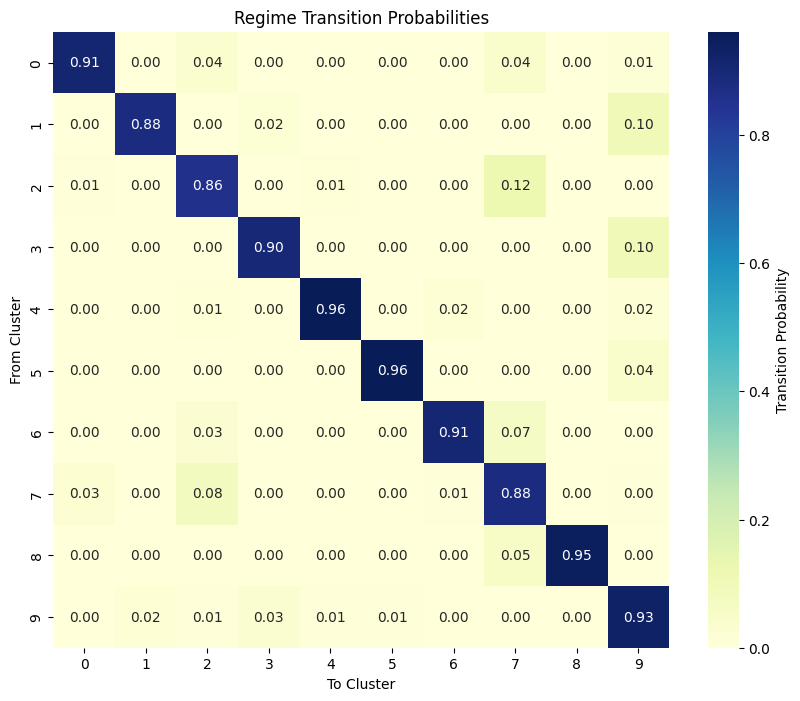

In [105]:
plot_transition_heatmap(transition_probs)